# Proyecto NLP

## Propósito Estudio

Sistema de detección de enlaces spam. Se desea implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL.

#### Librerías a utilizar

In [111]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#### Paso 1. Lectura del conjunto de datos

In [112]:
data_w=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

In [113]:
data_w.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [114]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


#### Paso 2: Procesamiento de datos

##### Eliminacion de registros duplicados

In [115]:
# Revision registros duplicados

dup=data_w.duplicated().sum()
print(dup,'Registros Duplicados')
data_w.drop_duplicates(inplace=True)
print(dup,'Registros Borrados') 

630 Registros Duplicados
630 Registros Borrados


Transformacion de Variable Objetivo de Categorica a Numerica

In [116]:
data_w["spam"] = data_w["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
data_w.head()

,url,is_spam,spam
0,https://briefingday.us8.list-manage.com/unsubs...,True,1
1,https://www.hvper.com/,True,1
2,https://briefingday.com/m/v4n3i4f3,True,1
3,https://briefingday.com/n/20200618/m#commentform,False,0
4,https://briefingday.com/fan,True,1


In [117]:
data_w['spam'].isnull().sum()

np.int64(0)

##### Chequeo de la data para ver si esta balanceada

In [118]:
data_w.spam.value_counts()

spam
0    2125
1     244
Name: count, dtype: int64

###### Despues de procesar el texto, realizare un oversampling, dado la poca cantidad de registros que tengo para realizar el modelo y puedo preservar información valiosa de la clase mayoritaria. La ejecucion del oversampling despues de procesar el texto me daria las siguientes ventajas:

- Reducción de Ruido: Al preprocesar el texto primero (tokenización, eliminación de stop words, lematización, etc.), se reduce el ruido en los datos. Esto significa que los ejemplos sintéticos generados durante el oversampling serán más representativos y menos ruidosos.

- Eficiencia: Preprocesar el texto antes de generar ejemplos sintéticos puede ser más eficiente en términos de tiempo y recursos computacionales, ya que estaria trabajando con datos más limpios y manejables.

- Mejor Representación: Al realizar el preprocesamiento antes del oversampling, aseguro que los ejemplos sintéticos se basen en una representación más precisa y limpia del texto original.

In [119]:
import regex as re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)

    # Eliminando las palabras https|www|com
    text = re.sub(r'https|www|com','', text, flags=re.IGNORECASE)

    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

data_w["url"] = data_w["url"].apply(preprocess_text)
data_w.head()

,url,is_spam,spam
0,"[briefingday, us, list, manage, unsubscribe]",True,1
1,[hvper],True,1
2,"[briefingday, v, i]",True,1
3,"[briefingday, m, mentform]",False,0
4,"[briefingday, fan]",True,1


##### Lematizacion del texto

In [120]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return ' '.join(tokens)

data_w["url"] = data_w["url"].apply(lemmatize_text)
data_w.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gfern\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gfern\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,url,is_spam,spam
0,briefingday list manage unsubscribe,True,1
1,hvper,True,1
2,briefingday,True,1
3,briefingday mentform,False,0
4,briefingday,True,1


##### Nube de palabras

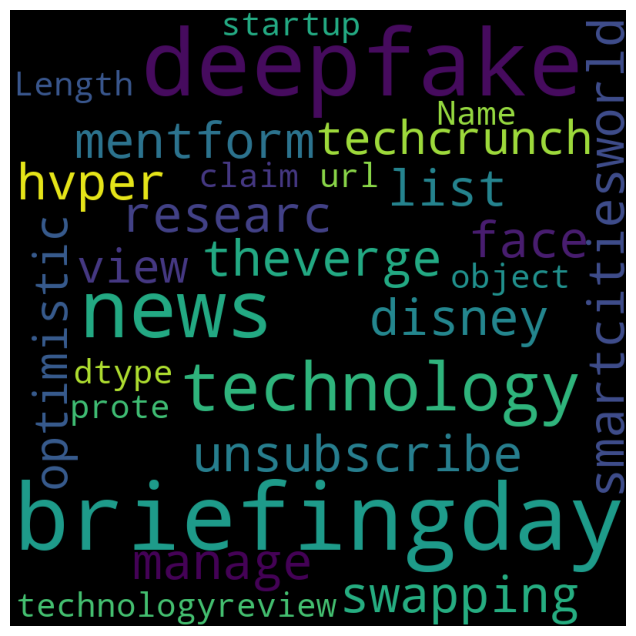

In [121]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(data_w["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### Division de la Data y Oversampling de la misma. Estoy tomando las siguientes consideraciones para realizar estas operaciones.

- Dimensionalidad Alta: Si vectorizo el texto antes de aplicar el oversampling, estaría trabajando con vectores de alta dimensionalidad. Esto puede hacer que el proceso de generación de ejemplos sintéticos sea más complejo y computacionalmente costoso.

- Representación Espacial: Los métodos de oversampling como SMOTE funcionan mejor en espacios de características continuas. Si aplico el oversampling después de vectorizar, especialmente con técnicas como TF-IDF, podría perder la estructura espacial de los datos originales, lo que puede afectar la calidad de los ejemplos sintéticos generados.

- Rendimiento del Modelo: La calidad de los ejemplos sintéticos generados después de la vectorización puede no ser tan buena como los generados en el espacio de características original. Esto puede llevar a un rendimiento sub-óptimo del modelo.

En una primera instancia con el texto preprocesado en una variable tipo 'pandas.core.series.Series' y la variable target en una variable del mismo tipo, se realiza el split de las variables en X_train, X_test, y_train, y_test.

Vectorizo con las variables X_train y X_test a través de variables tipo lista.

En este momento realizamos el Over_Sampling de las variables X_train vectorizada y y_train. Con estos dos arreglos nuevos obtenidos (1690 registros) se realiza el entrenamiento del modelo SVC

##### Split Train y Test

In [122]:
X_preprocesado=data_w['url']
y=data_w.iloc[:,2]
y.isnull().sum()

np.int64(0)

In [123]:
print(type(y))

<class 'pandas.core.series.Series'>


In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocesado, y, test_size=0.2, random_state=42)

In [125]:
X_train_lista=X_train.to_list()
X_test_lista=X_test.to_list()

##### Vectorización

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_lista).toarray()
X_test_vectorized = vectorizer.transform(X_test_lista).toarray()


In [127]:
print(type(X_train_vectorized))

<class 'numpy.ndarray'>


##### Over_Sampling

In [137]:
# Con el oversampling deben quedar las clases 0 y 1 de y_train con tamaño de 1690

y_train.value_counts()

spam
0    1690
1     205
Name: count, dtype: int64

In [128]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

In [138]:
y_train_resampled.value_counts()

spam
0    1690
1    1690
Name: count, dtype: int64

#### Paso 3: Inicialización y entrenamiento del modelo SVC

In [130]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear', random_state=42)

#### Paso 4: Predicción del modelo

In [131]:
y_pred = model.predict(X_test_vectorized)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,

In [132]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9240506329113924

In [135]:
from pickle import dump

dump(model, open("../models/svm_classifier_linear_42.sav", "wb"))

#### Conclusiones

Aparentemente el modelo tiene un buen accuracy, pero se pueden correr otros indicadores de desempeño del modelo como la matriz de confusión, curva ROC, entre otros.